# Importing Libraries

In [74]:
# import system libraries
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Librarie
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Read Data and store it in dataframe

In [2]:
data_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
filepaths, labels = [], []

folders = os.listdir(data_dir)
for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df

,filepaths,labels
0,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
1,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
2,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
3,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
4,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog
...,...,...
24997,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
24998,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
24999,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat
25000,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat


In [4]:
df['labels'].value_counts()

labels
Dog    12501
Cat    12501
Name: count, dtype: int64

**Check Image if Valid or not**

In [91]:
import PIL
from PIL import Image

# Function to handle potentially corrupted images
def is_valid_image(filepath):
    try:
        img = Image.open(filepath)
        img.verify()  # Verify that it is a readable image
        return True
    except (IOError, SyntaxError, PIL.UnidentifiedImageError):
        return False

# Filter the dataframe to remove invalid images
df['is_valid'] = df['filepaths'].apply(is_valid_image)

In [46]:
df['is_valid'].value_counts()

is_valid
True     24998
False        4
Name: count, dtype: int64

In [47]:
df[df['is_valid']== False]

,filepaths,labels,is_valid
3389,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog,False
8246,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Dog,False
20747,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat,False
22300,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,Cat,False


In [51]:
df.shape

(25002, 3)

In [52]:
# Drop rows where 'is_valid' is False
df = df[df['is_valid'] != False]

In [53]:
df.shape

(24998, 3)

## Visualization of image

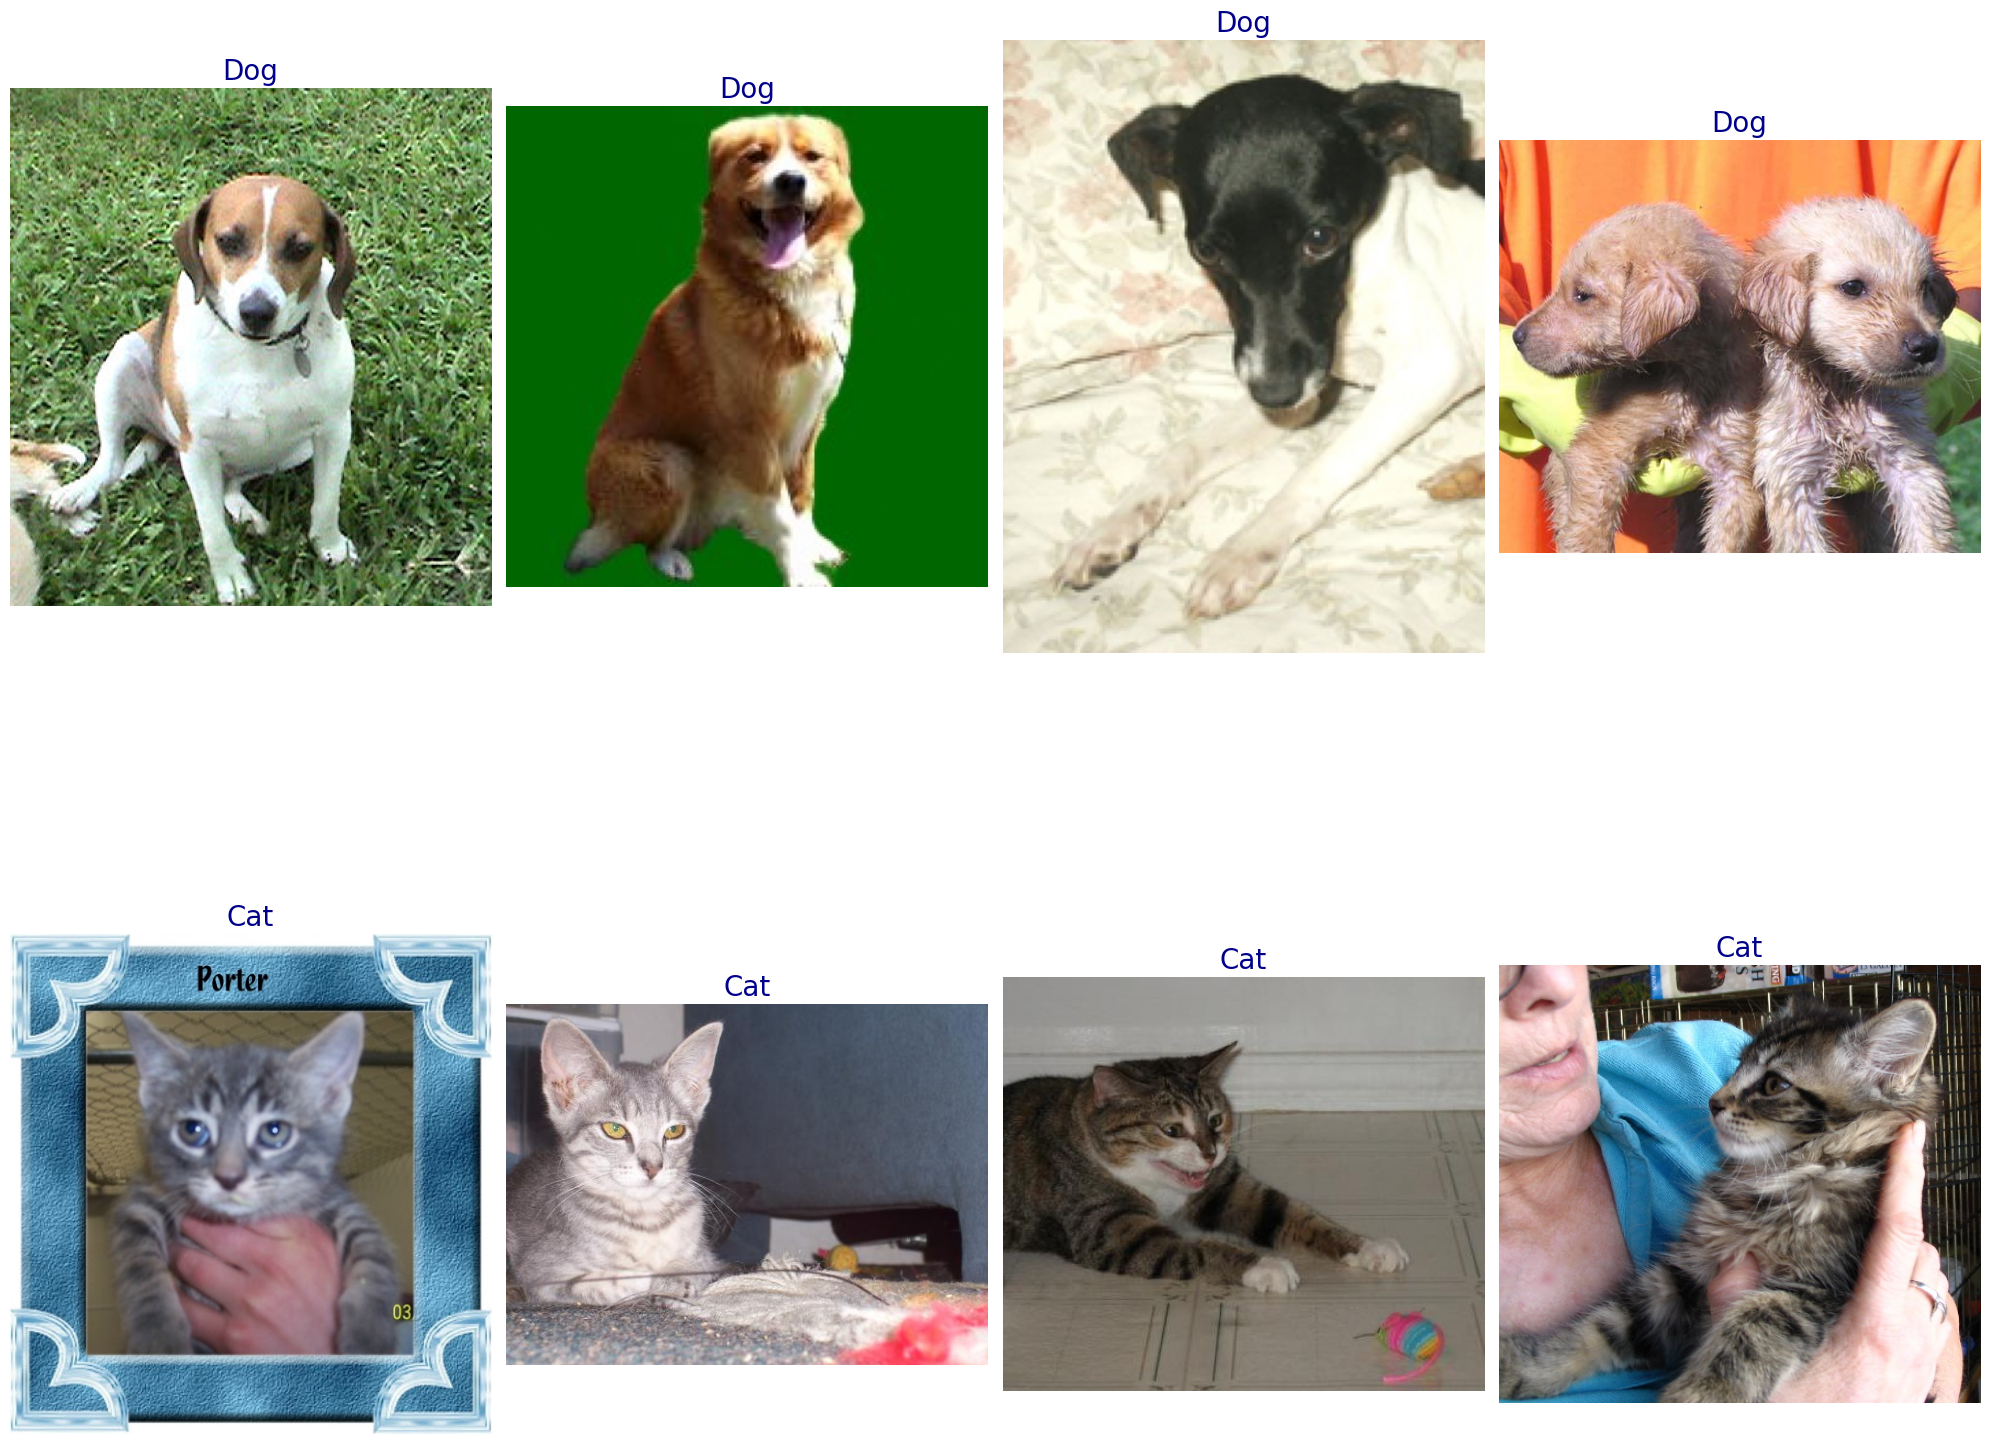

In [24]:
# Set the number of images to display per species
num_images = 4

# Get unique animal species labels
species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each animal species
for idx, anmal in enumerate(species):
    # Filter the DataFrame to get file paths for this animal species
    animal_df = df[df['labels'] == anmal].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(animal_df['filepaths'].values):
        plt.subplot(len(species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(anmal, fontdict={'fontsize': 20, 'color': 'darkblue'})
        
# Show the plot
plt.tight_layout()
plt.show()

## Spliting the data into Training and Testing

In [54]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, random_state=123, stratify=strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.3, shuffle=True, random_state=123, stratify=strat)

In [55]:
print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 17498
Number of Validation dataset: 5250
Number of Testing dataset: 2250


## Create image data generator

In [60]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True
                           )
ts_gen = ImageDataGenerator(rescale = 1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode= 'binary', 
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode= 'binary', 
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode= 'binary', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 17498 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames belonging to 2 classes.
Found 2250 validated image filenames belonging to 2 classes.


# Model Structure

In [61]:
# crobed image size
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape= img_shape),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
    
])

model.compile(Adamax(learning_rate=.0003), loss= 'binary_crossentropy', metrics=['acc'])

In [58]:
early_stopping = EarlyStopping(
    patience=10,
    mode= min,
    monitor='val_loss',
    verbose=0,
    min_delta=0,
    restore_best_weights=True,
    baseline=None
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    verbose=0,
    factor=.2
)

In [62]:
history = model.fit(train_gen, epochs=1000, validation_data=valid_gen, verbose=1, 
                    shuffle=False , callbacks=[early_stopping, plateau])

Epoch 1/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 284s 905ms/step - acc: 0.5271 - loss: 0.6884 - val_acc: 0.6522 - val_loss: 0.6111 - learning_rate: 3.0000e-04
Epoch 2/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 234s 853ms/step - acc: 0.6432 - loss: 0.6216 - val_acc: 0.7255 - val_loss: 0.5340 - learning_rate: 3.0000e-04
Epoch 3/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 233s 849ms/step - acc: 0.7176 - loss: 0.5500 - val_acc: 0.7480 - val_loss: 0.5053 - learning_rate: 3.0000e-04
Epoch 4/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 847ms/step - acc: 0.7336 - loss: 0.5272 - val_acc: 0.7682 - val_loss: 0.4844 - learning_rate: 3.0000e-04
Epoch 5/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 229s 834ms/step - acc: 0.7674 - loss: 0.4845 - val_acc: 0.8021 - val_loss: 0.4221 - learning_rate: 3.0000e-04
Epoch 6/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 237s 862ms/step - acc: 0.8010 - loss: 0.4305 - val_acc: 0.8303 - val_loss: 0.3782 - learning_rate: 3.0000e-04
Epoch 7/1000
274/274 ━━━━━━━━━━━━━━━━━━━━ 237s 866ms/step - acc: 0.8303 - loss: 0.3790 -

## Display model performance

In [63]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

### Loss Curve

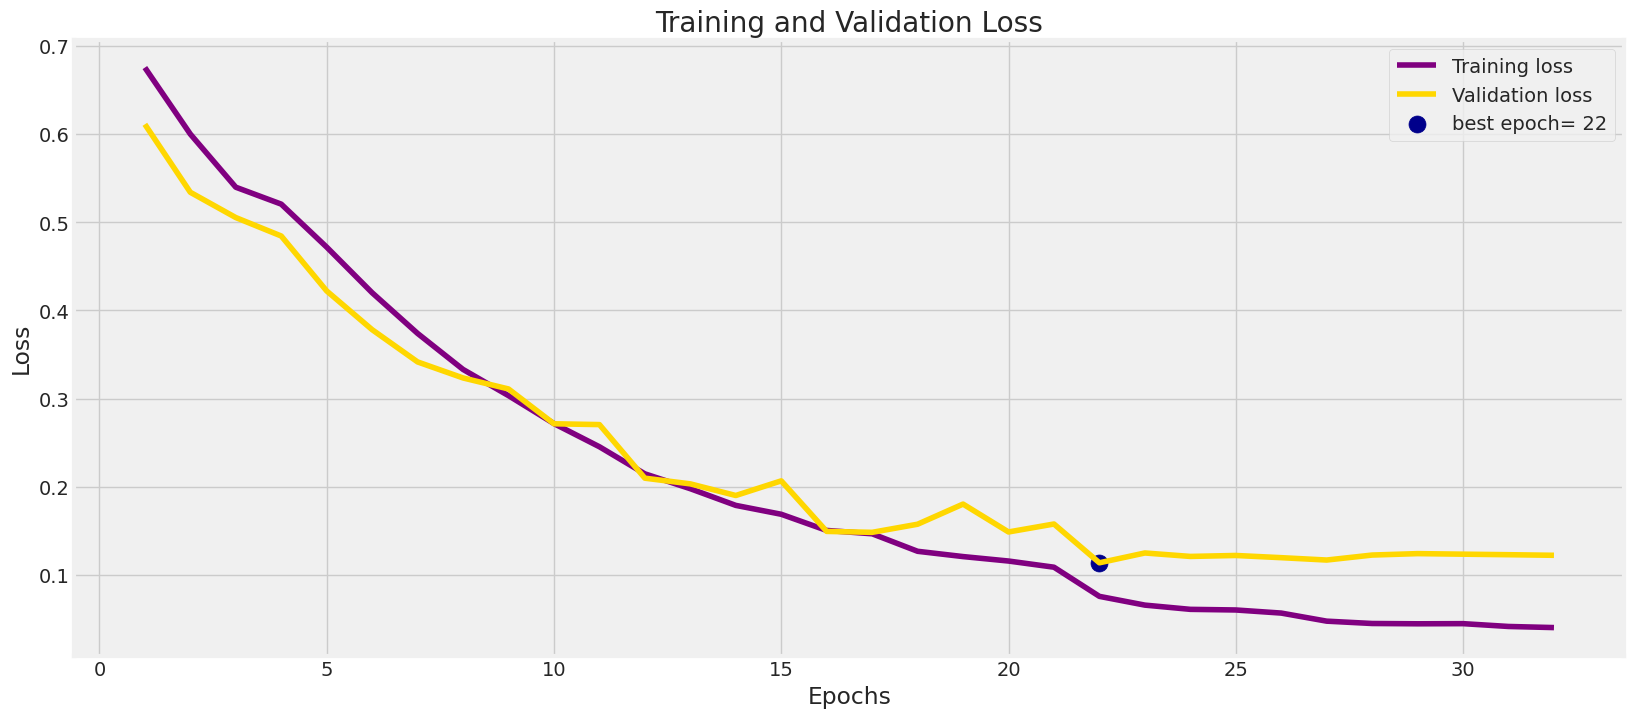

In [64]:
# Plot Training and Validation Loss
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show()

### Accurcy Curve

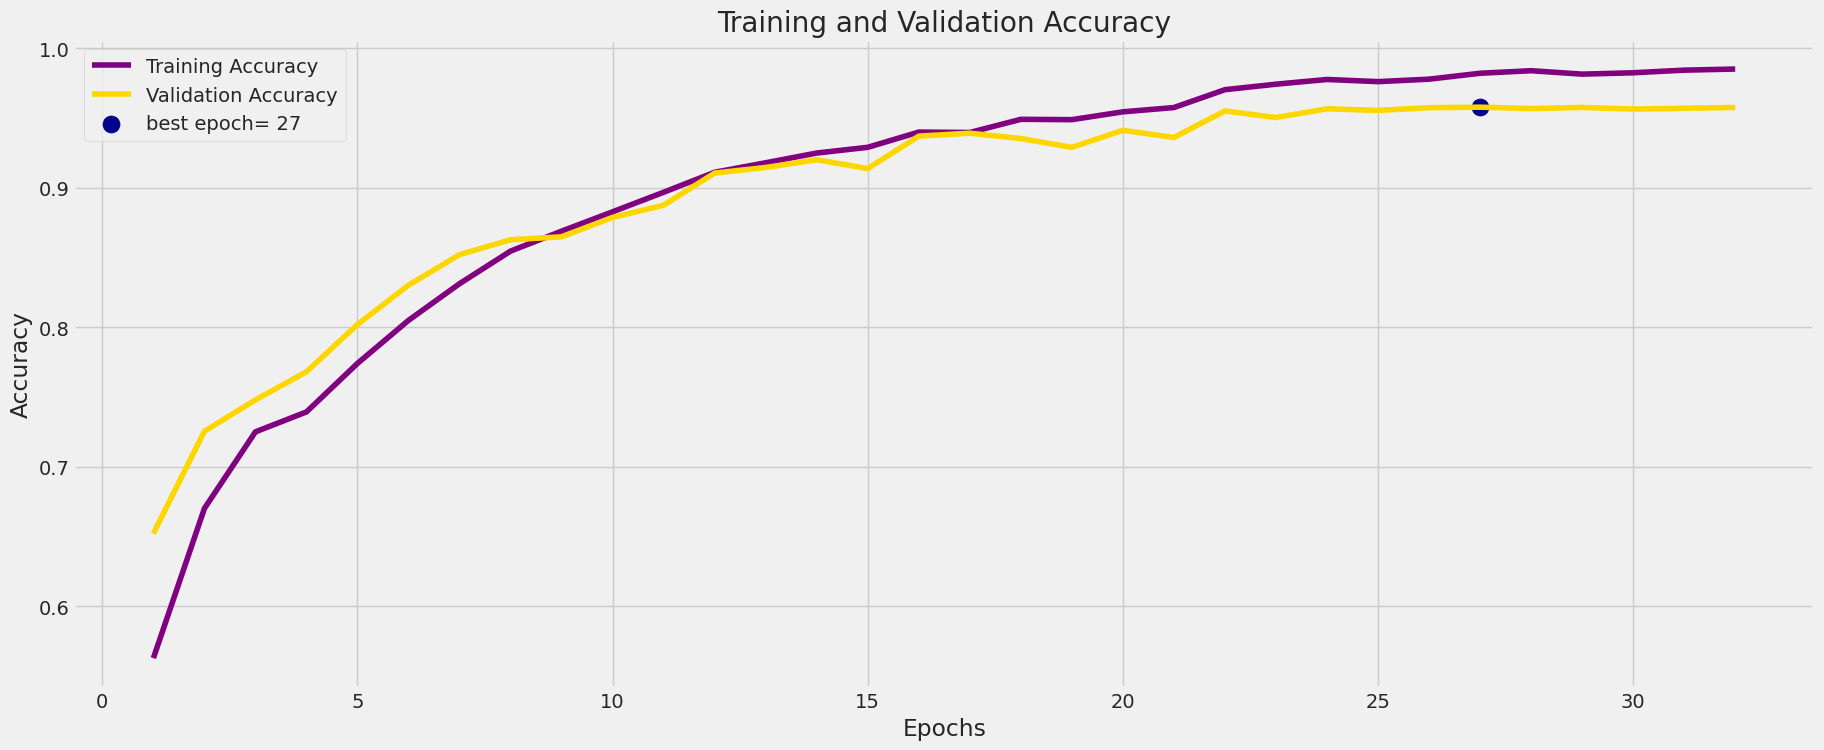

In [65]:
# Plot Training and Validation Accuracy
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evaluate model

In [66]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

274/274 ━━━━━━━━━━━━━━━━━━━━ 218s 794ms/step - acc: 0.9769 - loss: 0.0630
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - acc: 0.9576 - loss: 0.1115
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - acc: 0.9589 - loss: 0.1040
Train Loss:  0.06345564126968384
Train Accuracy:  0.976625919342041
--------------------
Valid Loss:  0.11385814100503922
Valid Accuracy:  0.9552381038665771
--------------------
Test Loss:  0.10850705206394196
Test Accuracy:  0.9564444422721863


# Get Predictions

In [81]:
preds  = model.predict(test_gen)

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step


In [82]:
preds

array([[8.2347441e-01],
       [1.4729330e-01],
       [9.3490402e-05],
       ...,
       [5.4221767e-01],
       [4.5065889e-08],
       [9.8801416e-01]], dtype=float32)

In [83]:
y_pred = np.argmax(preds, axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [85]:
g_dict

{'Cat': 0, 'Dog': 1}

In [86]:
classes

['Cat', 'Dog']

## Save Model

In [90]:
# Save the model 
model.save('model.h5')